Loading sequences: 100%|██████████| 2621/2621 [00:00<00:00, 700386.77it/s]


Features saved to ../dataset/demonstration_samples/GCF_000009645.1/features.pa
gff_df.csv saved to ../dataset/demonstration_samples/GCF_000009645.1/gff_df.csv
predicted_prob.csv saved to ../results/demonstration/GCF_000009645.1/predicted_prob.csv
predicted_function.csv saved to ../results/demonstration/GCF_000009645.1/predicted_function.csv
merged.csv saved

Function vectors for PICI:
Segment 1: [7, 7, 9, 9, 9, 9, 4, 4, 11, 9, 11, 9, 9, 5, 9, 5, 9, 11, 11, 11, 11, 11, 4, 11, 10, 9, 8, 7, 11, 4]
Location: NC_002745.2:2045419-2071086, reverse
Probability: 0.757

Segment 2: [10, 7, 7, 9, 9, 9, 9, 4, 4, 11, 9, 11, 9, 9, 5, 9, 5, 9, 11, 11, 11, 11, 11, 4, 11, 10, 9, 8, 7, 11]
Location: NC_002745.2:2046357-2072272, reverse
Probability: 0.857

Segment 3: [11, 10, 7, 7, 9, 9, 9, 9, 4, 4, 11, 9, 11, 9, 9, 5, 9, 5, 9, 11, 11, 11, 11, 11, 4, 11, 10, 9, 8, 7]
Location: NC_002745.2:2046902-2073957, reverse
Probability: 0.764



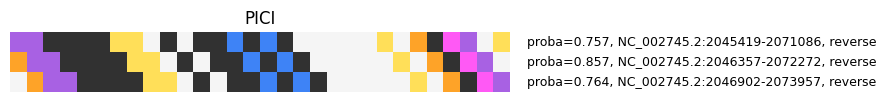

function
no_hit                                              1696
unknown_function                                     301
moron_auxiliary_metabolic_gene_and_host_takeover     234
dna_rna_and_nucleotide_metabolism                    150
other                                                 76
transcription_regulation                              44
head_and_packaging                                    39
lysis                                                 37
connector                                             18
tail                                                  13
integration_and_excision                              13
Name: count, dtype: int64


In [1]:
from pici_predictor.utilities import discover_pici

data_dir = "../dataset/demonstration_samples/GCF_000009645.1"
results_dir = "../results/demonstration/GCF_000009645.1"
model_function_path = "../models/best_configs"
model_pici_path = "../models/pici_classifier_model_max30.json"
pici_segments = discover_pici(
    data_dir, results_dir, model_function_path, model_pici_path, window_size=30
)

In [10]:
# import matplotlib.pyplot as plt

# plt.hist(pici_segments["prob_class_0"], bins=100)
# plt.yscale("log")
# plt.title("predicted probability of 'none'")
# plt.show()
# plt.hist(pici_segments["prob_class_1"], bins=100)
# plt.yscale("log")
# plt.title("predicted probability of 'PICI'")
# plt.show()
# plt.hist(pici_segments["prob_class_2"], bins=100)
# plt.yscale("log")
# plt.title("predicted probability of 'CFPICI'")
# plt.show()
# plt.hist(pici_segments["prob_class_3"], bins=100)
# plt.yscale("log")
# plt.title("predicted probability of 'P4-like'")
# plt.show()

# true pici

In [11]:
import pandas as pd

annotation = pd.read_parquet("../dataset/Phage_and_Satellites_Pann_Pcat_Pcol.pa")
sample_annotation = annotation[
    annotation["acc"].str.contains("STAU002_0321_00536_C001")
]
# STAU002.0321.00536.C001
sample_vec_function = sample_annotation["pcat"].values
# sample_vec_function

In [12]:
import numpy as np
from pici_predictor.phrog_function import (
    function_name_raw_to_num,
    function_num_to_color,
)

sample_vec = pd.Series(sample_vec_function).map(function_name_raw_to_num)
# reverse
sample_vec = np.array(sample_vec)
sample_vec = sample_vec[::-1]
sample_vec

array([10,  7,  7,  4,  9,  9,  9,  4,  4,  9,  9,  9,  9,  9,  5,  9,  5])

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_vector_heatmap(vec, function_num_to_color, save_path=None, title=None):
    """
    Plots a single-line heatmap for a vector using a custom color mapping.

    Args:
        vec (array-like): Vector of function numbers.
        function_num_to_color (dict): Mapping from function number to color code.
        save_path (str, optional): If provided, saves the heatmap to this path.
        title (str, optional): Title for the plot.
    """
    # Map each value in vec directly to its color
    color_row = [function_num_to_color[v] for v in vec]
    # Convert hex colors to RGB
    rgb_row = np.array([mcolors.to_rgb(c) for c in color_row]).reshape(1, -1, 3)

    fig, ax = plt.subplots(figsize=(len(vec) * 0.3, 0.6))
    ax.imshow(rgb_row, aspect="auto")
    ax.axis("off")
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.show()
    plt.close()

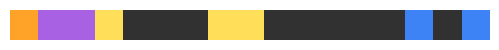

In [22]:
plot_vector_heatmap(
    sample_vec,
    function_num_to_color,
    # save_path="../results/demonstration/GCF_000009645.1/heatmap_true_pici.png",
    # title="real PICI",
)